# CCC

In [1]:
import time
import numpy as np
from arch import arch_model
# start_time = time.time()
# parameters = np.array([[0.05, 0.15, 0.75],
#                       [0.1, 0.25, 0.6],
#                       [0.15, 0.15, 0.8]])

# correlation_matrix =  np.array([[[1, 0.6, 0.4],
#                                  [0.6, 1, -0.3],
#                                  [0.4, -0.3, 1]]])


# decomp = np.linalg.cholesky(correlation_matrix)
# decomp
# # Number of observations
# T = 1000000
# K = correlation_matrix.shape[1]
# # Initialize arrays to store the processes and variances
# processes = np.zeros((K, T))
# variances = np.zeros((K, T))
# innovations = np.zeros((K, T))

# # Initial variance (can be set equal to the long-term variance)
# variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])

# # Simulate the GARCH processes
# for t in range(1, T):
#     # Simulate standard normal innovations
#     z = np.random.normal(0, 1, K)
#     # Apply the Cholesky decomposition to introduce correlation
#     correlated_z = decomp @ z
#     # Update the variance
#     variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
#     # Calculate the process values
#     processes[:, t] = np.sqrt(variances[:, t]) * correlated_z[:]

# # Output the first few values to check
# print(processes[:, :5])

# # End timing
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time

# # Print elapsed time with 5 digits after the decimal point
# print(f"Elapsed time: {elapsed_time:.5f} seconds")


In [2]:
def standard_deviations(data, univariate_parameters):
    K,T = data.shape
    sigmas = np.zeros((K,T))
    sigmas[:,0] = np.var(data, axis=1)
    for t in range(1, T):
        sigmas[:,t] = univariate_parameters[:,0] + univariate_parameters[:, 1] * data[:, t-1]**2 + univariate_parameters[:, 2] * sigmas[:, t-1]    
    return np.sqrt(sigmas)

def calculate_res(data, sigma):
    return data / sigma

def density(residuals):
    K, T = residuals.shape
    correlation_matrix = np.sum(np.einsum('it,jt->ijt', residuals, residuals), axis=-1) / T
    return correlation_matrix
    
def cholesky_scale(matrix):
    K, E = matrix.shape
    P = np.linalg.cholesky(matrix)
    for j in range(K):
        sum = np.sum(P[j, :j] ** 2)
        P[j,j] = np.sqrt(1-sum) if 1 - sum > 0 else 0
    scaled = np.dot(P, P.T)
    return scaled



def estimate_univariate(data):
    K, T = data.shape
    # Initialize an array to store the omega, alpha, and beta parameters for each series
    params_array = np.zeros((K, 3))
    
    for k in range(K):
        # Select the k-th series from the data
        series = data[k, :]
        
        # Fit a GARCH(1,1) model to the series
        model = arch_model(series, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off') # Set disp='off' to avoid printing the fit summary
        
        # Extract the parameters: omega (constant), alpha (ARCH), beta (GARCH)
        omega = model_fit.params['omega']
        alpha = model_fit.params['alpha[1]']
        beta = model_fit.params['beta[1]']
        
        # Store the parameters in the params_array
        params_array[k, :] = [omega, alpha, beta]
        
    return params_array




In [8]:
# import yfinance as yf
# # Seleccionar Criterio de Optimización
# optimization_criterion = 'cvar'  # Cambia a 'sharpe', 'cvar', 'sortino' o 'variance' para optimizar esos criterios

# # Elegir Acciones por agregar al Protafolio y Seleccionar periodo de muestra
# symbols = ['ACWI', 'TLT',]# 'EURGBP=X', 'EURCAD=X', 'EURCHF=X']
# start_date = '2015-01-01'
# end_date = '2024-01-01'

# data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# # Calcular los retornos
# returns = data.pct_change().dropna()

# data = returns.to_numpy().T * 100
# # print(data)
# means = np.mean(data, axis=1)
# data = data - means[:,np.newaxis]

# print( np.mean(data, axis=1))
# # # Define the list of stock symbols you're interested in

# # # Fetch the historical data
# datas = yf.download(symbols, start=start_date, end=end_date, interval='1d')['Adj Close']

# # # Calculate the log of the prices
# log_data = np.log(datas)
# dates = log_data.diff().dropna().index

# # Calculate the first difference of the log data
# log = log_data.diff().dropna().to_numpy()
# data = log.T * 100 + 1e-6
# print(data)
# Convert to numpy array
#log_returns_array = log_returns.to_numpy()
import numpy as np
import yfinance as yf
import numpy as np
import pandas as pd
import yfinance as yf

import numpy as np
import pandas as pd
import yfinance as yf

def process_stock_data(stock, start_date, end_date):
    """
    Download stock data, process it, and store the mean-adjusted returns.
    
    Parameters:
    - stocks: A list of stock ticker symbols.
    
    Returns:
    - mean_return: A pandas Series of mean-adjusted returns for each stock.
    - data: A DataFrame of mean-adjusted returns with stock tickers as column titles.
    """

    # Download the stock data
    data = yf.download(stocks, start=start_date, end=end_date, interval='1wk')['Adj Close']

    # Forward fill to handle NaN values that might occur
    data.ffill(inplace=True)

    # Take the log of closing prices and then the first difference, multiply by 100
    log_returns = np.log(data + 1e-6).diff().dropna() * 100

    # Handling infinite values by replacing them with NaN
    log_returns.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Optionally, drop rows with any NaN values after handling infinite values
    log_returns.dropna(inplace=True)

    # Calculate the mean of each stock
    mean_returns = log_returns.mean()

    # Subtract the mean from each stock's log returns
    mean_adjusted_data = log_returns - mean_returns

    return mean_returns, mean_adjusted_data
start_date = '2014-01-01'
end_date = '2024-01-01'

# Example usage
stocks = ['ACWI', 'MINV.L', 'SPY', 'TLT',] 
# start_date = '2014-01-01'
# end_date = '2024-01-01'

# # Example usage
# stocks = ['ACWI', 'TLT', 'MINV.L','IBGL.AS','SPY', 'SHY',]# 'AAPL', 'GOOGL', 'MSFT', 'AMZN']
mean_returns, data = process_stock_data(stocks, start_date, end_date)

print(data.head())
# Get Column Labels
labels = data.columns.tolist()
data = data.to_numpy().T

print(data)
print(mean_returns)
#print(log_returns_array)
# data = pd.read_csv('C2A.csv').to_numpy().T * 100
K, T = data.shape
N = 2
univariate_parameters = estimate_univariate(data)

# correlation_matrix, transition_matrix, log_hist, u_hat, standard_deviations = fit(data, univariate_parameters, num_states=N, max_it=300)

[*********************100%%**********************]  4 of 4 completed
                ACWI    MINV.L       SPY       TLT
Date                                              
2014-01-08  0.287452 -0.352692 -0.113891  1.495308
2014-01-15  0.093680 -0.212781  0.059886  1.018436
2014-01-22 -3.091906 -2.911432 -3.031020  1.306908
2014-01-29 -2.571310 -0.530886 -2.293926  1.049009
2014-02-05  3.803611  1.817590  3.471085 -1.358359
[[ 0.28745189  0.09367993 -3.09190583 ...  2.59811109 -0.62205009
   0.89348594]
 [-0.35269154 -0.21278052 -2.91143246 ... -1.86799999 -0.04430834
   0.91048876]
 [-0.11389083  0.0598855  -3.03101976 ...  2.07039191  0.35765426
  -0.28889958]
 [ 1.49530803  1.01843581  1.30690761 ...  4.37526113  0.15146567
   0.0827575 ]]
ACWI      0.151038
MINV.L    0.184765
SPY       0.217397
TLT       0.038663
dtype: float64


In [6]:

std = standard_deviations(data, univariate_parameters)
res = calculate_res(data, std)
correlation_matrix = density(res)
corr = cholesky_scale(correlation_matrix)
print(corr)


[[ 1.          0.38919844  0.93855099 -0.13291495]
 [ 0.38919844  1.          0.45359521  0.06475018]
 [ 0.93855099  0.45359521  1.         -0.13211766]
 [-0.13291495  0.06475018 -0.13211766  1.        ]]


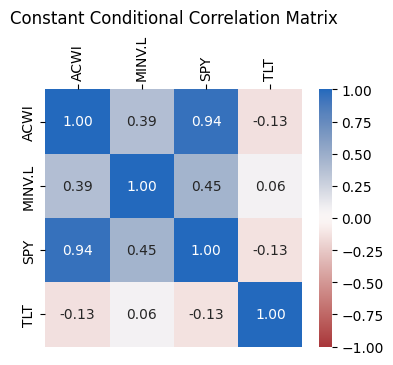

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns
# def plot_correlation_matrices(correlation_matrix, labels, both=False):
#     # Set up the figure size
#     plt.figure(figsize=(5, 4))
    
#     # Plot the heatmap and get the axes object
#     ax = sns.heatmap(correlation_matrix, annot=True, cmap='vlag_r', fmt=".2f",
#                      xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1)
    
#     # Move x-axis to the top
#     ax.xaxis.tick_top()
    
#     # Optionally, you can also rotate the labels if needed
#     plt.xticks(rotation=90)  # Rotate x-axis labels if they overlap or for better readability
    
#     plt.title(f'Constant Conditional Correlation Matrix', y=1.1)  # Adjust title position
    
#     plt.tight_layout()
#     plt.savefig('CCC Heatmap.png')
#     plt.show()
def plot_correlation_matrices(correlation_matrix, labels, both=False):
    # Determine figure dimensions for square tiles
    # Increase figure height to ensure labels don't overlap with the title
    n = len(labels)
    fig_height = n * 1  # Adjust the multiplier as needed for spacing
    fig_width = n * 1
    plt.figure(figsize=(fig_width, fig_height - 0.4))  # Added 2 inches for extra space for title and labels
    
    # Plot the heatmap and get the axes object
    ax = sns.heatmap(correlation_matrix, annot=True, cmap='vlag_r', fmt=".2f",
                     xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1, square=True)
    
    # Move x-axis to the top and rotate the labels for readability
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    
    # Adjust title position and padding to prevent overlap with x-axis labels
    plt.title(f'Constant Conditional Correlation Matrix', y=1.15, pad=20,fontsize=12)
    
    plt.tight_layout()
    plt.savefig('CCC Heatmap.png')
    plt.show()

plot_correlation_matrices(corr, labels)

In [7]:

standard_deviations = np.mean(std, axis=1)
diag = np.diag(standard_deviations)
cov = diag @ corr @ diag
cov


array([[ 4.28831097,  1.19877134,  3.98109748, -0.50223413],
       [ 1.19877134,  2.21230115,  1.38195019,  0.1757326 ],
       [ 3.98109748,  1.38195019,  4.19569205, -0.49380098],
       [-0.50223413,  0.1757326 , -0.49380098,  3.32949623]])

In [8]:
import numpy as np
from numpy.linalg import inv
import cvxpy as cp

def optimize_portfolio(cov_matrix, expected_returns, target_return):
    """
    Finds the optimal portfolio weights using Markowitz optimization.
    
    Parameters:
    - cov_matrix: A covariance matrix of asset returns.
    - expected_returns: An array of expected returns for each asset.
    - target_return: The target return for the portfolio.
    
    Returns:
    - A tuple (weights, risk), where 'weights' is an array of optimal asset weights, and 'risk' is the portfolio risk (standard deviation).
    """
    num_assets = len(expected_returns)
    
    # Define the optimization variables
    weights = cp.Variable(num_assets)
    
    # Define the objective function (minimize portfolio variance)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    
    # Define the constraints
    constraints = [
        cp.sum(weights) == 1,  # Sum of weights must be 1
        weights >= 0,          # No short selling
        cp.matmul(weights, expected_returns) >= target_return  # Target return constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Extract the optimal weights and calculate portfolio risk
    optimal_weights = weights.value
    portfolio_risk = cp.sqrt(portfolio_variance).value
    
    return optimal_weights, portfolio_risk

 # Correct matrix multiplication for covariance
data =  data + means[:,np.newaxis]
# mu_1 = np.mean(data * u_hat[0], axis=1)  # Expected returns vector
# mu_2 = np.mean(data * u_hat[1], axis=1)  # Expected returns vector
mu = np.mean((data),axis=1)
mu_p = 0.02  # Target return
print(f'Returns Combined :  \n{mu}')
# print(f'Returns in state 1:  \n{mu_1}')
# print(f'Returns in state 2:  \n{mu_2}')


# optimal_weights_1, portfolio_risk_1 = optimize_portfolio(cov_1, mu_1, mu_p)
# optimal_weights_2, portfolio_risk_2 = optimize_portfolio(cov_2, mu_2, mu_p)
optimal_weights, portfolio_risk = optimize_portfolio(cov, mu, mu_p)
print(f'Optimal Weigts Combined :  \n{optimal_weights}')
# print(f'Optimal Weigts in state 1:  \n{optimal_weights_1}')
# print(f'Optimal Weigts in state 2:  \n{optimal_weights_2}')
print(portfolio_risk)#, portfolio_risk_1, portfolio_risk_2)
retun = optimal_weights * mu
mean_return = np.mean(retun)
sharpe = mean_return / portfolio_risk
sharpe

Returns Combined :  
[0.0387716  0.00290152]
Optimal Weigts Combined :  
[0.47820266 0.52179734]
0.5956010378585088


0.016835672919725767

In [9]:
from scipy.stats import t

# T-statistic from the user's message
t_stat = 3.58678288007606

# Degrees of freedom from the user's message
df = 4524

# Calculate the p-value for the two-tailed test for the given t-statistic
# Since it's a two-tailed test, we need to multiply by 2
p_value = t.sf(t_stat, df) * 2  # sf is the survival function (1 - cdf)

p_value


0.00033832175723903633

In [20]:
import numpy as np
from numpy.linalg import inv
import cvxpy as cp

def optimize_portfolio(cov_matrix, expected_returns, target_return):
    """
    Finds the optimal portfolio weights using Markowitz optimization.
    
    Parameters:
    - cov_matrix: A covariance matrix of asset returns.
    - expected_returns: An array of expected returns for each asset.
    - target_return: The target return for the portfolio.
    
    Returns:
    - A tuple (weights, risk), where 'weights' is an array of optimal asset weights, and 'risk' is the portfolio risk (standard deviation).
    """
    num_assets = len(expected_returns)
    
    # Define the optimization variables
    weights = cp.Variable(num_assets)
    
    # Define the objective function (minimize portfolio variance)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    
    # Define the constraints
    constraints = [
        cp.sum(weights) == 1,  # Sum of weights must be 1
        weights >= 0,          # No short selling
        cp.matmul(weights, expected_returns) >= target_return  # Target return constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Extract the optimal weights and calculate portfolio risk
    optimal_weights = weights.value
    portfolio_risk = cp.sqrt(portfolio_variance).value
    
    return optimal_weights, portfolio_risk

 # Correct matrix multiplication for covariance


mu = np.mean(data, axis=1)
mu_p = 0.01  # Target return
print(f'Returns: {mu}')

optimal_weights, portfolio_risk = optimize_portfolio(cov, mu, mu_p)
print(f'Optimal Weigts Combined :  \n{optimal_weights}')

portfolio_risk
retun = optimal_weights * mu
mean_return = np.mean(retun)
sharpe = mean_return / portfolio_risk
sharpe

Returns: [0.03685569 0.00353043]
Optimal Weigts Combined :  
[0.48428832 0.51571168]


0.017743666752914767

0.018035913471360313

# Multi state


In [5]:
import time
import numpy as np

start_time = time.time()
parameters = np.array([[0.05, 0.15, 0.75],
                      [0.1, 0.25, 0.6],
                      [0.15, 0.15, 0.8],
                      [0.2, 0.3, 0.65]])

true_correlation_matrix =  matrices = np.array([
    # High correlations
    [[1, 0.8, 0.7, 0.6],
     [0.8, 1, 0.65, 0.55],
     [0.7, 0.65, 1, 0.5],
     [0.6, 0.55, 0.5, 1]],
    
    # Low correlations
    [[1, 0.1, 0.15, 0.05],
     [0.1, 1, 0.2, 0.1],
     [0.15, 0.2, 1, 0.12],
     [0.05, 0.1, 0.12, 1]],
    
    # Negative correlations
    [[1, -0.5, -0.4, -0.3],
     [-0.5, 1, -0.2, -0.1],
     [-0.4, -0.2, 1, -0.25],
     [-0.3, -0.1, -0.25, 1]],
    
    # In between
    [[1, 0.4, -0.3, 0.2],
     [0.4, 1, 0.25, -0.2],
     [-0.3, 0.25, 1, 0.15],
     [0.2, -0.2, 0.15, 1]]
])
diagonal = 0.99
N = 4
K = 4
transition_matrix = diagonal * np.eye(N) + (1-diagonal) * (np.ones((N,N)) - np.eye(N,N)) / (N - 1)
decomp = np.zeros((N, K, K))
for n in range(N):
    decomp[n,:,:] = choleski_form(true_correlation_matrix[n,:,:])


# Number of observations
T = 10000000

# Initialize arrays to store the processes and variances
processes = np.zeros((K, T))
variances = np.zeros((K, T))
states = np.zeros((T))
innovations = np.zeros((K, T))

# Initial variance (can be set equal to the long-term variance)
variances[:, 0] = parameters[:, 0] / (1 - parameters[:, 1] - parameters[:, 2])
states[0] = 0
# Simulate the GARCH processes
for t in range(1, T):
    state = int(states[t-1])
    current_state = np.random.choice(a=[0,1,2,3], p=transition_matrix[state])
    states[t] = current_state
    
    # Simulate standard normal innovations
    z = np.random.normal(0, 1, K)
    # Apply the Cholesky decomposition to introduce correlation
    correlated_z = decomp[current_state,:,:] @ z
    # Update the variance
    variances[:, t] = parameters[:, 0] + parameters[:, 1] * (processes[:, t-1]**2) + parameters[:, 2] * variances[:, t-1]
    # Calculate the process values
    processes[:, t] = np.sqrt(variances[:, t]) * correlated_z[:]











# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print elapsed time with 5 digits after the decimal point
print(f"Elapsed time: {elapsed_time:.5f} seconds")


Elapsed time: 384.48471 seconds


In [6]:
def choleski_form(matrix):
    return np.linalg.cholesky(matrix)
def standard_deviations(data, univariate_parameters):
    K,T = data.shape
    sigmas = np.zeros((K,T))
    sigmas[:,0] = np.var(data, axis=1)
    for t in range(1, T):
        sigmas[:,t] = univariate_parameters[:,0] + univariate_parameters[:, 1] * data[:, t-1]**2 + univariate_parameters[:, 2] * sigmas[:, t-1]    
    return np.sqrt(sigmas)

def calculate_res(data, sigma):
    return data / sigma

def density(residuals,states):
    K, T = residuals.shape
    sum_states = np.sum(states, axis=-1)
    correlation_matrix = np.sum(np.einsum('it,jt,nt->nijt', residuals, residuals, states), axis=-1) /sum_states
    return correlation_matrix
    
def cholesky_scale(matrix):
    K, E = matrix.shape
    P = np.linalg.cholesky(matrix)
    for j in range(K):
        sum = np.sum(P[j, :j] ** 2)
        P[j,j] = np.sqrt(1-sum) if 1 - sum > 0 else 0
    scaled = np.dot(P, P.T)
    return scaled

def form_states(states, N, T):
    # Ensure states are integers within the correct range
    states = np.clip(states.astype(int), 0, N-1)
    
    # Initialize the state array with zeros
    state_array = np.zeros((N, T))
    
    # Mark ones for active states
    for t, state in enumerate(states):
        state_array[state, t] = 1
    
    return state_array


start_time = time.time()


std = standard_deviations(processes, parameters)
res = calculate_res(processes, std)
true_states = form_states(states, N, T)
correlation_matrix = density(res, true_states)
scaled = np.zeros((N, K, K))
for n in range(N):
    scaled[n,:,:] = cholesky_scale(correlation_matrix[n,:,:])


print(scaled)
# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print elapsed time with 5 digits after the decimal point
print(f"Elapsed time: {elapsed_time:.5f} seconds")


[[[ 1.          0.8019691   0.70110199  0.60104857]
  [ 0.8019691   1.          0.64973254  0.54983106]
  [ 0.70110199  0.64973254  1.          0.50393924]
  [ 0.60104857  0.54983106  0.50393924  1.        ]]

 [[ 1.          0.10025644  0.15013322  0.04949751]
  [ 0.10025644  1.          0.20025296  0.09852301]
  [ 0.15013322  0.20025296  1.          0.12017861]
  [ 0.04949751  0.09852301  0.12017861  1.        ]]

 [[ 1.         -0.49841708 -0.39797933 -0.29952701]
  [-0.49841708  1.         -0.20194527 -0.09944296]
  [-0.39797933 -0.20194527  1.         -0.24991191]
  [-0.29952701 -0.09944296 -0.24991191  1.        ]]

 [[ 1.          0.40045791 -0.29903808  0.19978641]
  [ 0.40045791  1.          0.2499614  -0.19981725]
  [-0.29903808  0.2499614   1.          0.15010042]
  [ 0.19978641 -0.19981725  0.15010042  1.        ]]]
Elapsed time: 41.94825 seconds


In [ ]:
correlation_matrix

In [ ]:
scaled

In [ ]:
true_correlation_matrix

In [7]:
emission  = scaled - true_correlation_matrix
np.max(emission),np.min(emission), emission

(0.0039392418367781845,
 -0.0019452746091170592,
 array([[[ 0.00000000e+00,  1.96909865e-03,  1.10199299e-03,
           1.04857276e-03],
         [ 1.96909865e-03,  0.00000000e+00, -2.67456206e-04,
          -1.68936372e-04],
         [ 1.10199299e-03, -2.67456206e-04,  0.00000000e+00,
           3.93924184e-03],
         [ 1.04857276e-03, -1.68936372e-04,  3.93924184e-03,
           2.22044605e-16]],
 
        [[ 0.00000000e+00,  2.56437986e-04,  1.33222412e-04,
          -5.02488696e-04],
         [ 2.56437986e-04,  0.00000000e+00,  2.52957837e-04,
          -1.47698584e-03],
         [ 1.33222412e-04,  2.52957837e-04,  0.00000000e+00,
           1.78610192e-04],
         [-5.02488696e-04, -1.47698584e-03,  1.78610192e-04,
          -1.11022302e-16]],
 
        [[ 0.00000000e+00,  1.58292403e-03,  2.02067146e-03,
           4.72987738e-04],
         [ 1.58292403e-03,  0.00000000e+00, -1.94527461e-03,
           5.57036258e-04],
         [ 2.02067146e-03, -1.94527461e-03,  0.00000000

In [ ]:
transition_matrix